In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns



In [2]:
# unpickle trips.pkl
trips = pd.read_pickle('trips_1M.pkl')
print(len(trips))

FileNotFoundError: [Errno 2] No such file or directory: 'trips_1M.pkl'

In [33]:

trip = trips[300]


print(len(trip[1]))
trip_id = trip[0]
trip_X = trip[1]
trip_y = trip[2]
trip_y_pred = trip[3]

# convert trip_X to dataframe
df = pd.DataFrame(trip_X, columns=['AbsoluteTime','Latitude', 'Longitude','Tsurf', 'Ta','Hours','Speed'])

df['friction'] = trip_y
df['friction_pred'] = trip_y_pred


198


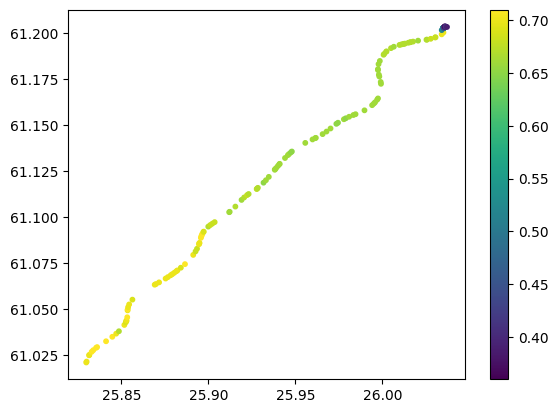

In [34]:
# scatter plot of friction in a lat long 2D space
plt.scatter(df['Longitude'], df['Latitude'], c=df['friction'], cmap='viridis', s=10)
plt.colorbar()
plt.show()

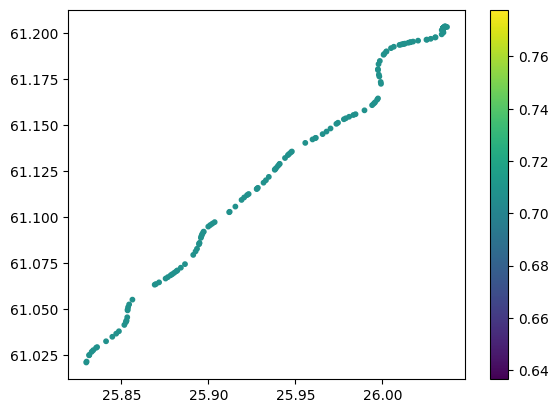

In [35]:
# scatter plot of friction in a lat long 2D space
plt.scatter(df['Longitude'], df['Latitude'], c=df['friction_pred'], cmap='viridis', s=10)
plt.colorbar()
plt.show()


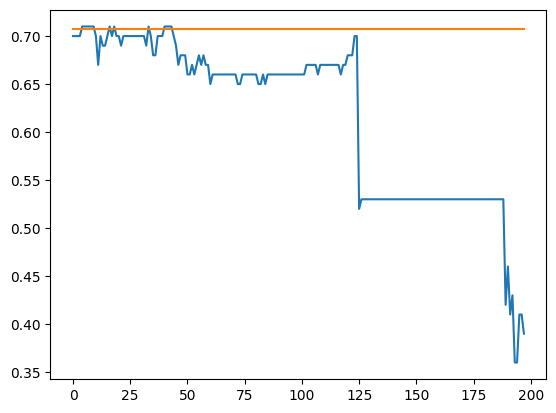

In [36]:
# plot friction and friction_pred in time in line plot
df['friction'].plot()
df['friction_pred'].plot()
plt.show()
